Each file represents a sample in either 'bare' or 'treated' state.
Each file contains 10 consequtive scans on the sample.

The purpose of this notebook, is to look at the variability between these 10 scans on the same sample.
If there is variability, they can be used as individual datapoints, as opposed to being averaged to a single scan, to increase the size of the dataset.
Even though the scans are done on the same sample, it can be viewed as a form of data augmentation, where it is the same datapoint but with different noise applied

In [46]:
import math
import os
import pickle
from datetime import datetime
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import numpy as np
import optuna
from scipy.signal import correlate
from scipy.signal.windows import tukey
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tqdm import tqdm

In [47]:
data_path = "Data/Ex-Vivo/final_data.pkl"
data_folder_path = "Data/Ex-Vivo/"

# Load individual files and create the final data object
files = os.listdir("Data/Ex-Vivo/")

if "READ_ME.txt" in files:
    files.remove("READ_ME.txt")

data = []

for file in tqdm(files, desc="Loading files"):
    with open(os.path.join(data_folder_path, file), 'rb') as f:
        data.append(pickle.load(f))

for d in data:
    timestamp = d['time']
    d['date'] = datetime.fromisoformat(timestamp)

data = sorted(data, key=lambda x: x['date'])

# performing basic preprocessing

# Fixing labeling errors
data[51]['samplematrix'] = 'sample 7 PBS'
data[51]['conc'] = 0.0

data[52]['samplematrix'] = 'sample 8 g/PBS'
data[52]['conc'] = 2.5

data[53]['samplematrix'] = 'sample 6 g/PBS'
data[53]['conc'] = 2.5


# Fixing issue with sample ids due to multiple days
for d in data:
    d['samplematrix_fixed'] = d['samplematrix']

for d in data[37:]:
    values = d['samplematrix'].split()
    if len(values) > 1:
        id = int(values[1])
        new_id = id+18
        new_samplematrix = values[0] + " " + str(new_id) + " " + values[2]
        d['samplematrix_fixed'] = new_samplematrix


# Removing air and NC as these are irrelevant for our purpose
data = [d for d in data if not d['samplematrix_fixed'] == 'air']

ids_to_remove = []

for d in data:
    values = d['samplematrix_fixed'].split()
    if values[2] == 'NC':
        ids_to_remove.append(values[1])

data = [d for d in data if not d['samplematrix_fixed'].split()[1] in ids_to_remove]

Loading files: 100%|██████████| 95/95 [00:10<00:00,  8.78it/s]


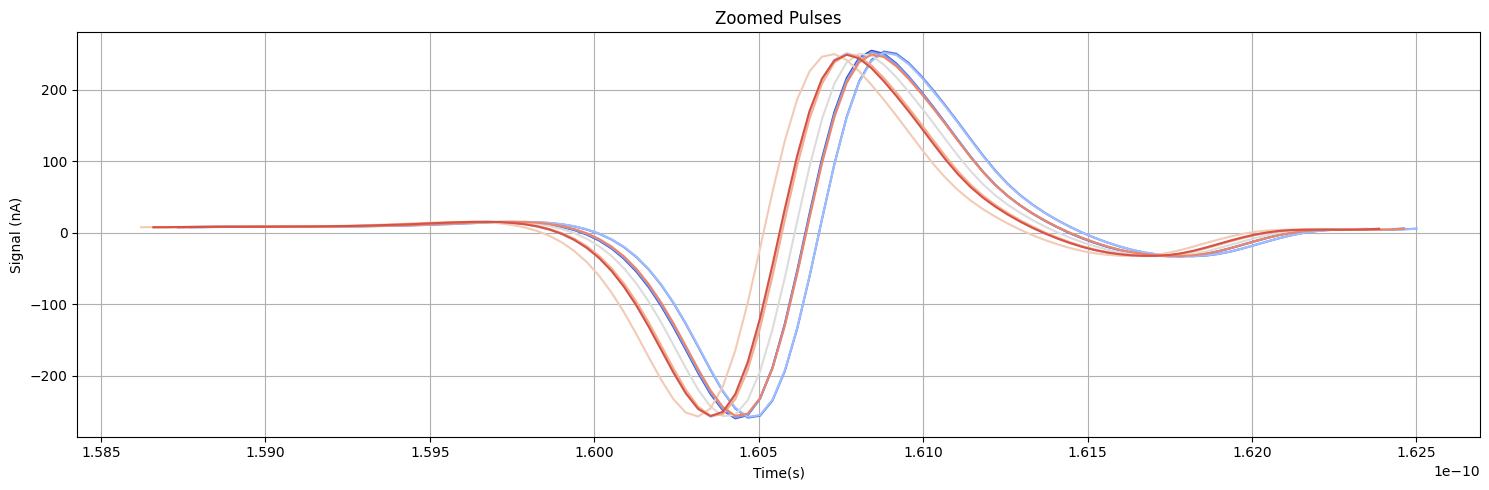

In [48]:
# Plotting all scans from the same sample

plt.figure(figsize=(15, 5))

number_of_pulses = len(data[0]['scan'])

for i in range(0, number_of_pulses):
    x = data[0]['scan'][i]['forward_scan']['time']
    y = data[0]['scan'][i]['forward_scan']['signal']

    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index + max_index) / 2)
    zoom_start = middle_index - 50
    zoom_end = middle_index + 50

    color = plt.cm.coolwarm(i / number_of_pulses)

    plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Pulse ' + str(i), color=color)

plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulses")
plt.grid(True)

plt.tight_layout()
plt.show()


Length of the first pulse:  24900
max shift:  5
Length of the first pulse after cropping:  24890


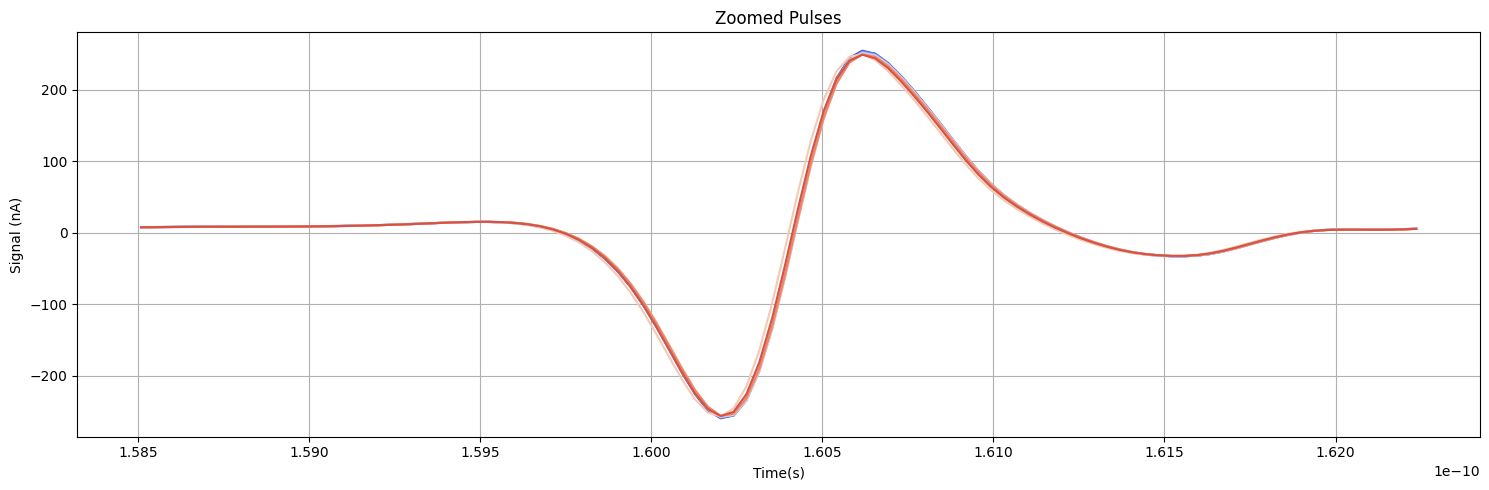

In [49]:
# Aligning the pulses using cross correlation and using the first pulse as reference
# only for the first sample and forward scans

print("Length of the first pulse: ", len(data[0]['scan'][0]['forward_scan']['signal']))

current_max_shift = 0 # used later for cropping the signals

reference = data[0]['scan'][0]['forward_scan']['signal']

for i in range(0,10):
    forward_signal = data[0]['scan'][i]['forward_scan']['signal']
    backward_signal = data[0]['scan'][i]['backward_scan']['signal']
    ref_signal_forward = data[0]['ref'][i]['forward_scan']['signal']
    ref_signal_backward = data[0]['ref'][i]['backward_scan']['signal']


    forward_correlation = correlate(reference, forward_signal)
    backward_correlation = correlate(reference, backward_signal)
    ref_forward_correlation = correlate(reference, ref_signal_forward)
    ref_backward_correlation = correlate(reference, ref_signal_backward)
    
    forward_shift = np.argmax(forward_correlation) - len(forward_signal)
    backward_shift = np.argmax(backward_correlation) - len(backward_signal)
    ref_forward_shift = np.argmax(ref_forward_correlation) - len(ref_signal_forward)
    ref_backward_shift = np.argmax(ref_backward_correlation) - len(ref_signal_backward)

    aligned_forward_signal = np.roll(forward_signal, forward_shift)
    aligned_backward_signal = np.roll(backward_signal, backward_shift)
    aligned_ref_signal_forward = np.roll(ref_signal_forward, ref_forward_shift)
    aligned_ref_signal_backward = np.roll(ref_signal_backward, ref_backward_shift)

    data[0]['scan'][i]['forward_scan']['signal_aligned'] = aligned_forward_signal
    data[0]['scan'][i]['backward_scan']['signal_aligned'] = aligned_backward_signal
    data[0]['ref'][i]['forward_scan']['signal_aligned'] = aligned_ref_signal_forward
    data[0]['ref'][i]['backward_scan']['signal_aligned'] = aligned_ref_signal_backward

    max_shift = max(abs(forward_shift), abs(backward_shift), abs(ref_forward_shift), abs(ref_backward_shift))

    if max_shift > current_max_shift:
        current_max_shift = max_shift

print("max shift: ", current_max_shift)

# Cutting out the ends of the signal

for i in range(0,10):
    data[0]['scan'][i]['forward_scan']['signal_aligned'] = data[0]['scan'][i]['forward_scan']['signal_aligned'][current_max_shift:-current_max_shift]
    data[0]['scan'][i]['backward_scan']['signal_aligned'] = data[0]['scan'][i]['backward_scan']['signal_aligned'][current_max_shift:-current_max_shift]
    data[0]['ref'][i]['forward_scan']['signal_aligned'] = data[0]['ref'][i]['forward_scan']['signal_aligned'][current_max_shift:-current_max_shift]
    data[0]['ref'][i]['backward_scan']['signal_aligned'] = data[0]['ref'][i]['backward_scan']['signal_aligned'][current_max_shift:-current_max_shift]

print("Length of the first pulse after cropping: ", len(data[0]['scan'][0]['forward_scan']['signal_aligned']))

# Plotting the aligned pulses

plt.figure(figsize=(15, 5))

for i in range(0, 10):
    x = data[0]['scan'][i]['forward_scan']['time']
    y = data[0]['scan'][i]['forward_scan']['signal_aligned']

    min_index = np.argmin(y)
    max_index = np.argmax(y)
    middle_index = math.floor((min_index + max_index) / 2)
    zoom_start = middle_index - 50
    zoom_end = middle_index + 50

    color = plt.cm.coolwarm(i / number_of_pulses)

    plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Pulse ' + str(i), color=color)


plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulses")
plt.grid(True)

plt.tight_layout()
plt.show()

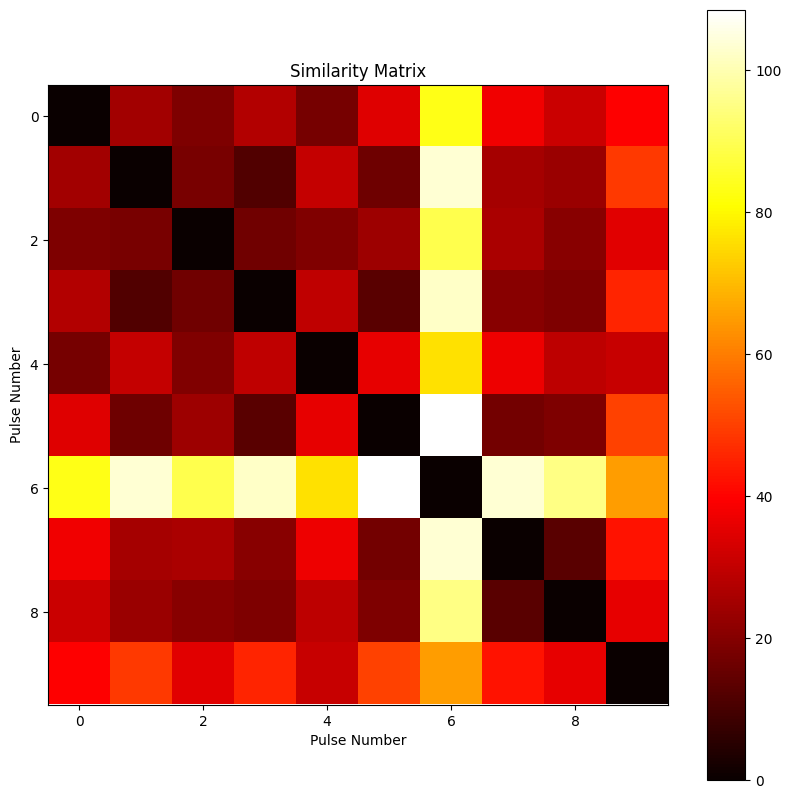

In [50]:

def calculate_similarity(scan1, scan2):
    return np.linalg.norm(scan1 - scan2)

# Calculating the similarity between all pulses

similarity_matrix = np.zeros((number_of_pulses, number_of_pulses))

for i, scan in enumerate(data[0]['scan']):
    for j, scan2 in enumerate(data[0]['scan']):
        similarity = calculate_similarity(scan['forward_scan']['signal_aligned'], scan2['forward_scan']['signal_aligned'])
        similarity_matrix[i, j] = similarity

plt.figure(figsize=(10, 10))
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Similarity Matrix")
plt.xlabel("Pulse Number")
plt.ylabel("Pulse Number")
plt.show()




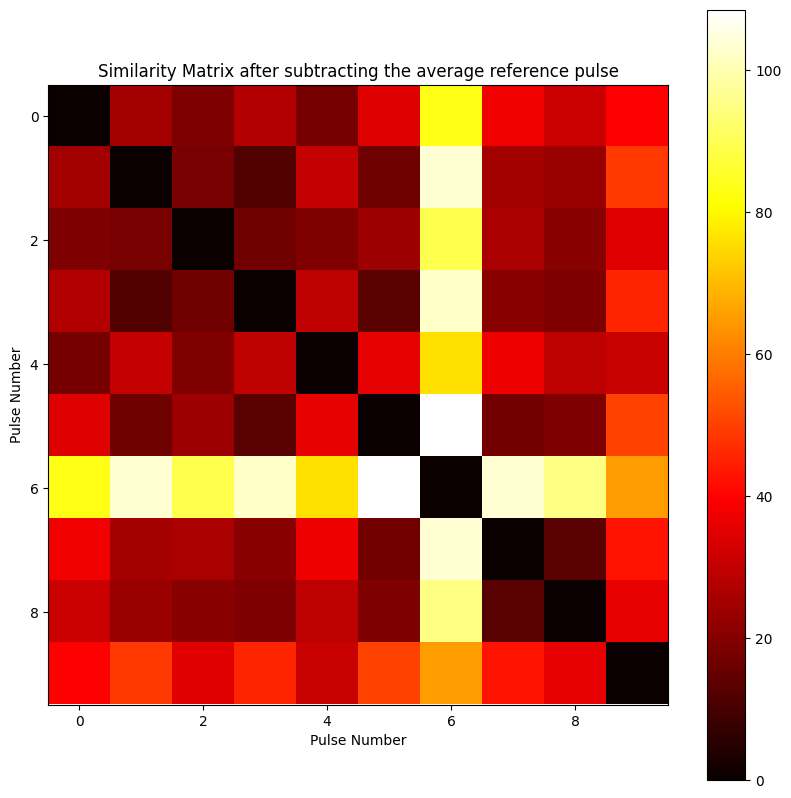

In [51]:
# average the ref pulse
average_reference_pulse = np.zeros(len(data[0]['ref'][0]['forward_scan']['signal_aligned']))

ref_pulses = [ref['forward_scan']['signal_aligned'] for ref in data[0]['ref']]
avg_ref_pulse = np.mean(ref_pulses, axis=0)
data[0]['avg_ref_pulse'] = avg_ref_pulse

# subtracting the avg ref pulse from the scan pulses
for scan in data[0]['scan']:
    scan['forward_scan']['signal_ref_subtracted'] = scan['forward_scan']['signal_aligned'] - avg_ref_pulse


#Calculating similarity between scan pulses after subtracting the avg ref pulse

similarity_matrix_ref_subtracted = np.zeros((10, 10))

for i, scan in enumerate(data[0]['scan']):
    for j, scan2 in enumerate(data[0]['scan']):
        similarity = calculate_similarity(scan['forward_scan']['signal_ref_subtracted'], scan2['forward_scan']['signal_ref_subtracted'])
        similarity_matrix_ref_subtracted[i, j] = similarity


plt.figure(figsize=(10, 10))
plt.imshow(similarity_matrix_ref_subtracted, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Similarity Matrix after subtracting the average reference pulse")
plt.xlabel("Pulse Number")
plt.ylabel("Pulse Number")
plt.show()





conclusion:
- The 10 different pulses within the SAME sample has some variation even AFTER aligning
- Subtracting the avg ref pulse does not make a difference in the variance between them, as the same operation has been applied to all of them

We can therefore use the 10 different pulses from same SAMPLE as augmented data and increase our dataset

Question, what about forward and backwards signals? Do they also contain variance or are they identical? If they contain variance after aligning, then they can also be used as extra data.

In [54]:
# calculating similarity between forward and backwards scans
def calculate_similarity(scan1, scan2):
    return np.linalg.norm(scan1 - scan2)

similarity_array = np.zeros(10)


for i, scan in enumerate(data[0]['scan']):
    similarity = calculate_similarity(scan['forward_scan']['signal_aligned'], scan['backward_scan']['signal_aligned'])
    similarity_array[i] = similarity

print(similarity_array)

[203.41412559 202.40323902 201.97337888 206.78596244 215.85159473
 200.81624299 212.1411787  203.17068354 194.58995691 197.31412092]


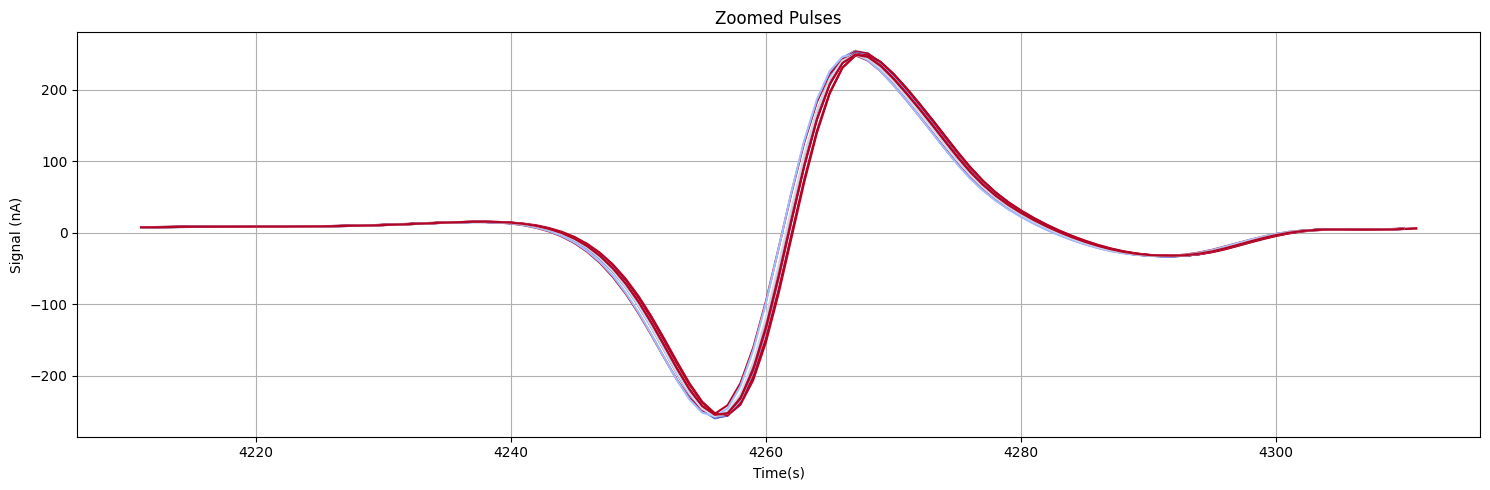

In [56]:
# Plotting all scans from the same sample

plt.figure(figsize=(15, 5))

number_of_pulses = len(data[0]['scan'])

for i in range(0, number_of_pulses):
    x = range(len(data[0]['scan'][i]['forward_scan']['signal_aligned']))
    x_back = range(len(data[0]['scan'][i]['backward_scan']['signal_aligned']))
    y = data[0]['scan'][i]['forward_scan']['signal_aligned']
    y_back = data[0]['scan'][i]['backward_scan']['signal_aligned']

    min_index = np.argmin(y)
    min_index_back = np.argmin(y_back)
    max_index = np.argmax(y)
    max_index_back = np.argmax(y_back)
    middle_index = math.floor((min_index + max_index) / 2)
    middle_index_back = math.floor((min_index_back + max_index_back) / 2)
    zoom_start = middle_index - 50
    zoom_start_back = middle_index_back - 50
    zoom_end = middle_index + 50
    zoom_end_back = middle_index_back + 50

    color = plt.cm.coolwarm(i / 20)
    color_back = plt.cm.coolwarm(i+10 / 20)

    plt.plot(x[zoom_start:zoom_end], y[zoom_start:zoom_end], label='Pulse ' + str(i), color=color)
    plt.plot(x_back[zoom_start_back:zoom_end_back], y_back[zoom_start_back:zoom_end_back], label='Pulse ' + str(i+10), color=color_back)



plt.xlabel("Time(s)")
plt.ylabel("Signal (nA)")
plt.title("Zoomed Pulses")
plt.grid(True)

plt.tight_layout()
plt.show()


In [57]:
np.linalg.norm(data[0]['scan'][0]['forward_scan']['signal_aligned'] - data[0]['scan'][0]['backward_scan']['signal_aligned'])

203.41412558943222

conclusion on forward/backward scans:
- Even between forward and backward scans there is some variability.
- Therefore, each file now contributes with 20 individual datapoints (10 from the forward scan, and 10 from the backward scan). This greatly increases the size of the dataset.
